# apply NDE sampled IVAR to noiseless SED
This notebook is an example of how it's done

In [1]:
import os
import numpy as np

In [62]:
from provabgs import util as UT

In [2]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [14]:
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.nn import functional as F

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [8]:
dat_dir = '/scratch/network/chhahn/sedflow/training_sed/'

ibatch = 0
wave = np.load(os.path.join(dat_dir, f'train.v0.1.{ibatch}.waves.npy'))
seds = np.load(os.path.join(dat_dir, f'train.v0.1.{ibatch}.seds.npy'))[:10]
zred = np.load(os.path.join(dat_dir, f'train.v0.1.{ibatch}.redshifts.npy'))[:10]
theta = np.load(os.path.join(dat_dir, f'train.v0.1.{ibatch}.thetas_sps.npy'))[:10]

In [5]:
# read in SDSS spectra
rawspec = np.load(os.path.join('/scratch/network/chhahn/sedflow/spectra/', 'sdss_spectra.100000.npz')) # SDSS dr16 spectra
w_sdss = 10**rawspec['wave']

wlim = (wave > w_sdss[0]) & (wave < w_sdss[-1])

In [10]:
A_spec = np.array([np.median(sed[_w]) for sed, _w in zip(seds, wlim)])

In [6]:
dat_dir = '/scratch/network/chhahn/sedflow/spectra/'
i_best = 6
h_ivar = np.load(os.path.join(dat_dir, f'ivar.vae_model.{i_best}.latvar.npy'))
A_ivar = np.load(os.path.join(dat_dir, f'ivar.vae_model.{i_best}.ivar_norm.npy'))
A_spec_vae = np.load(os.path.join(dat_dir, f'ivar.vae_model.{i_best}.spec_norm.npy'))
zred_vae = np.load(os.path.join(dat_dir, f'ivar.vae_model.{i_best}.zred.npy'))

In [7]:
N_train = 1000
y_train = np.concatenate([h_ivar, A_ivar], axis=1)[N_train:]
x_train = np.concatenate([np.log10(A_spec_vae.clip(1e-2, None)), zred_vae], axis=1)[N_train:]

# read in NDE
lower_bounds = torch.tensor([-4, -10, -7, -5, -16, 0])
upper_bounds = torch.tensor([10, 3.5, 7, 5, 5.5, 17])

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

# load NDE
best_arch = '279x8'
nhidden, nblocks = 279, 8
fanpe = os.path.join(dat_dir, f'sdss_ivar.noise_nde.{best_arch}.pt')

anpe = Inference.SNPE(prior=prior,
                      density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
                      device='cpu')
# load ANPE
anpe.append_simulations(
    torch.as_tensor(y_train.astype(np.float32)),
    torch.as_tensor(x_train.astype(np.float32)))

phat = anpe._build_neural_net(torch.as_tensor(y_train.astype(np.float32)), torch.as_tensor(x_train.astype(np.float32)))
phat.load_state_dict(torch.load(fanpe, map_location=torch.device('cpu')))

anpe._x_shape = Ut.x_shape_from_simulation(torch.as_tensor(y_train.astype(np.float32)))

best_phat = anpe.build_posterior(phat)

In [11]:
# assign h, A_ivar
h_Aivar = []
for i in range(len(zred)):
    _y = best_phat.sample((1,), x=torch.as_tensor(np.array([np.log10(A_spec[i].clip(1e-2, None)), zred[i]]).flatten().astype(np.float32)).to('cpu'),
            show_progress_bars=False)
    h_Aivar.append(np.array(_y.detach().to('cpu')[0]))
h_Aivar = np.array(h_Aivar)

In [39]:
vae_dict = torch.load(os.path.join('/scratch/network/chhahn/sedflow/spectra/', f'ivar.vae_model.{i_best}.pt'))
avg_ivar = np.load(os.path.join('/scratch/network/chhahn/sedflow/spectra/', 'ivar.avg.npy'))
std_ivar = np.load(os.path.join('/scratch/network/chhahn/sedflow/spectra/', 'ivar.std.npy'))

In [15]:
class InfoVAE(nn.Module):
    def __init__(self, nwave=1000, ncode=5, alpha=0, lambd=10000, 
                 nkernels=[3, 3, 3], nhiddens_enc=[128, 64, 32], nhiddens_dec=[128, 64, 32], npools=[2, 2, 2], 
                 dropout=0.2):
        super(InfoVAE, self).__init__()
        
        self.ncode = int(ncode)
        self.alpha = float(alpha)
        self.lambd = float(lambd)

        nkernel0, nkernel1, nkernel2 = nkernels
        nhidden0_enc, nhidden1_enc, nhidden2_enc = nhiddens_enc
        nhidden0_dec, nhidden1_dec, nhidden2_dec = nhiddens_enc
        npool0, npool1, npool2 = npools

        # convolutional layers
        self.conv0 = nn.Conv1d(1, 1, kernel_size=nkernel0)
        Lout = nwave - nkernel0 + 1 
        self.p0 = nn.MaxPool1d(npool0)
        Lout = int((Lout - npool0)/npool0 + 1)
        self.conv1 = nn.Conv1d(1, 1, kernel_size=nkernel1)
        Lout = Lout - nkernel1 + 1 
        self.p1 = nn.MaxPool1d(npool1)
        Lout = int((Lout - npool1)/npool1 + 1)
        self.conv2 = nn.Conv1d(1, 1, kernel_size=nkernel2)
        Lout = Lout - nkernel2 + 1 
        self.p2 = nn.MaxPool1d(npool2)
        Lout = int((Lout - npool2)/npool2 + 1)

        # encoders
        self.enc0 = nn.Linear(Lout, nhidden0_enc)
        self.d1 = nn.Dropout(p=dropout)
        self.enc1 = nn.Linear(nhidden0_enc, nhidden1_enc)
        self.d2 = nn.Dropout(p=dropout)
        self.enc2 = nn.Linear(nhidden1_enc, nhidden2_enc)
        self.d3 = nn.Dropout(p=dropout)

        self.mu = nn.Linear(nhidden2_enc, ncode)
        self.lv = nn.Linear(nhidden2_enc, ncode)
        
        # decoders
        self.decd = nn.Linear(ncode, nhidden2_dec)
        self.d3 = nn.Dropout(p=dropout)
        self.decd2 = nn.Linear(nhidden2_dec, nhidden1_dec)
        self.d4 = nn.Dropout(p=dropout)
        self.decd3 = nn.Linear(nhidden1_dec, nhidden0_dec)
        self.d5 = nn.Dropout(p=dropout)
        self.outp = nn.Linear(nhidden0_dec, nwave)
        
    def encode(self, x):
        x = self.p0(F.relu(self.conv0(x)))
        x = self.p1(F.relu(self.conv1(x)))
        x = self.p2(F.relu(self.conv2(x)))
        x = self.d1(F.leaky_relu(self.enc0(x)))
        x = self.d2(F.leaky_relu(self.enc1(x)))
        x = self.d3(F.leaky_relu(self.enc2(x)))

        mu = self.mu(x)
        logvar = self.lv(x)
        return mu[:,0,:], logvar[:,0,:]
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, x):
        x = self.d3(F.leaky_relu(self.decd(x)))
        x = self.d4(F.leaky_relu(self.decd2(x)))
        x = self.d5(F.leaky_relu(self.decd3(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_kernel(self, x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        # The example code divides by (dim) here, making <kernel_input> ~ 1/dim
        # excluding (dim) makes <kernel_input> ~ 1
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)#/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size)
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_mmd(self, x, y):
        xx_kernel = self.compute_kernel(x,x)
        yy_kernel = self.compute_kernel(y,y)
        xy_kernel = self.compute_kernel(x,y)
        return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)
    
    def loss(self, x, mask):
        recon_x, mu, logvar = self.forward(x)

        MSE = torch.sum(0.5 * ((x[:,0,:] - recon_x)[~mask]).pow(2))
        
        # KL divergence (Kingma and Welling, https://arxiv.org/abs/1312.6114, Appendix B)
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #return MSE + self.beta*KLD, MSE
                
        # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
        device = x.device
        true_samples = Variable(torch.randn(200, self.ncode), requires_grad=False)
        true_samples = true_samples.to(device)

        z = self.reparameterize(mu, logvar) #duplicate call
        z = z.to(device)
        # compute MMD ~ 1, so upweight to match KLD which is ~ n_batch x n_code
        MMD = self.compute_mmd(true_samples,z) * x.size(0) * self.ncode
        return MSE + (1-self.alpha)*KLD + (self.lambd+self.alpha-1)*MMD, MSE, KLD, MMD

In [29]:
nhiddens_enc = [vae_dict['enc0.weight'].shape[0], vae_dict['enc1.weight'].shape[0], vae_dict['enc2.weight'].shape[0]]
nhiddens_dec = nhiddens_enc # accidentally set them as the same

In [31]:
model = InfoVAE(
        alpha=0, 
        lambd=0, 
        nwave=len(w_sdss), 
        nkernels=[2, 2, 2], 
        npools=[2, 2, 2],
        nhiddens_enc=nhiddens_enc,
        nhiddens_dec=nhiddens_dec,
        ncode=5, 
        dropout=0)

In [32]:
model.load_state_dict(vae_dict)

<All keys matched successfully>

In [35]:
h_Aivar

array([[-2.09868282e-01, -3.01820487e-01,  1.13499306e-01,
        -8.57956886e-01,  4.36798066e-01,  6.13887191e-01],
       [ 3.72409081e+00, -3.36322260e+00,  9.40679789e-01,
         1.81126320e+00, -2.09684873e+00,  1.77401733e+00],
       [ 6.85691738e+00, -2.73696613e+00,  4.73738003e+00,
        -4.90212727e+00, -1.89858592e+00,  1.20422663e-03],
       [-2.46410608e+00,  1.52652323e+00, -9.76265728e-01,
         1.20425522e+00, -1.09866548e+00,  3.35058117e+00],
       [ 5.91910183e-01,  2.20156240e+00, -1.02629757e+00,
         1.96076536e+00,  7.87506580e-01,  2.76832676e+00],
       [-1.49299848e+00, -7.70462304e-02,  5.99571764e-01,
         1.98718503e-01, -1.18077826e+00,  3.59104300e+00],
       [ 4.97454613e-01,  8.71116757e-01, -5.96227467e-01,
         1.49023259e+00, -8.92525136e-01,  2.89634252e+00],
       [-1.08018482e+00,  5.30334771e-01, -9.74462450e-01,
        -1.80534005e+00,  7.52492666e-01,  1.50749993e+00],
       [ 5.52308893e+00,  2.90478095e-02,  3.612

In [77]:
model.decode(torch.tensor(h_Aivar[:,:-1])).detach().cpu().numpy()

array([[-1.1634482e+00, -9.9790287e-01, -1.1085217e+00, ...,
        -8.5669575e+00, -1.6487022e+01,  2.1748617e-03],
       [-1.3918618e+00, -1.2742980e+00, -1.2825029e+00, ...,
        -1.0310798e+01, -1.9995893e+01,  2.2772836e-02],
       [-1.2888976e+00, -9.5355177e-01, -8.4844732e-01, ...,
        -9.7739296e+00, -1.8735411e+01,  2.1661388e-02],
       ...,
       [-1.1632706e+00, -9.9739885e-01, -1.0727444e+00, ...,
        -8.5700588e+00, -1.6562853e+01,  5.0379820e-03],
       [-1.3918614e+00, -1.1779885e+00, -1.1856433e+00, ...,
        -1.0436770e+01, -2.0218348e+01,  5.2165776e-02],
       [-1.1974773e+00, -9.9447274e-01, -1.0750607e+00, ...,
        -8.7798080e+00, -1.6817753e+01,  1.1531418e-02]], dtype=float32)

In [78]:
w_ivar = model.decode(torch.tensor(h_Aivar[:,:-1])).detach().cpu().numpy()

ivar_recon = (w_ivar * std_ivar + avg_ivar) * h_Aivar[:,-1][:,None]

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


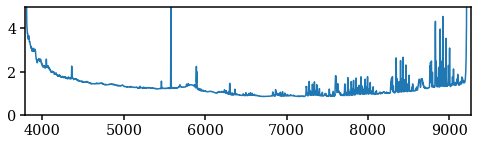

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


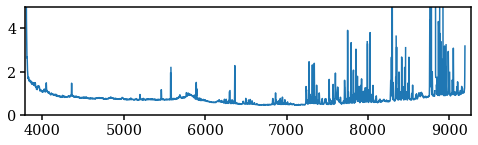

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


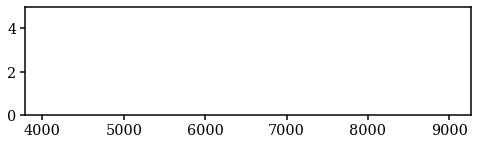

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


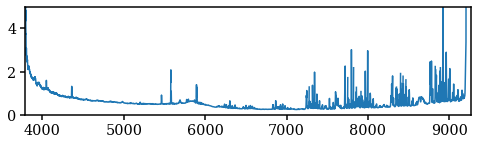

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


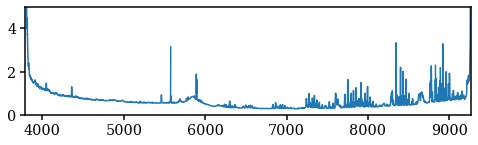

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


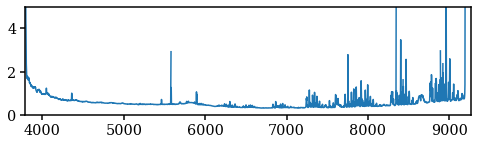

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


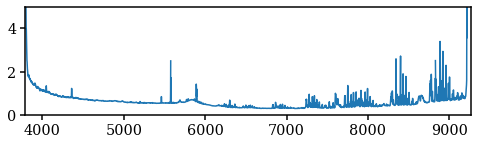

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


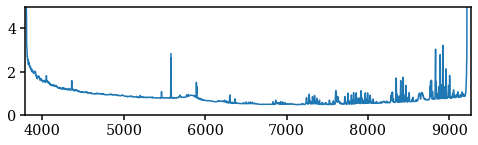

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


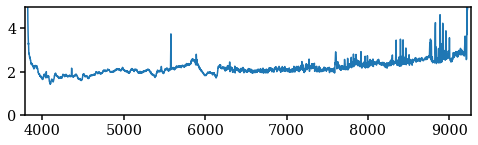

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


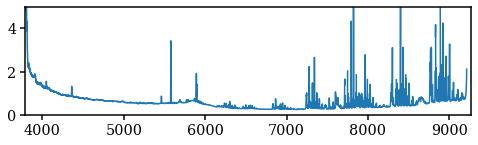

In [79]:
for ivar in ivar_recon:
    fig = plt.figure(figsize=(8,2))
    sub = fig.add_subplot(111)

    sub.plot(w_sdss, ivar**-0.5)
    sub.set_xlim(w_sdss[0], w_sdss[-1])
    sub.set_ylim(0, 5)
    plt.show()

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


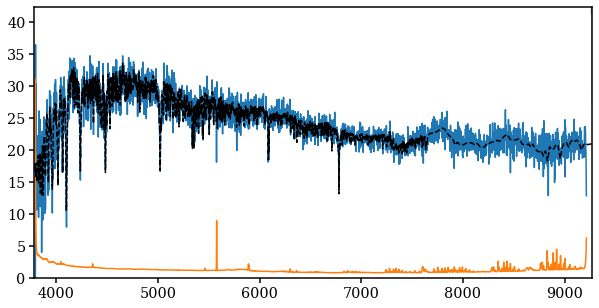

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


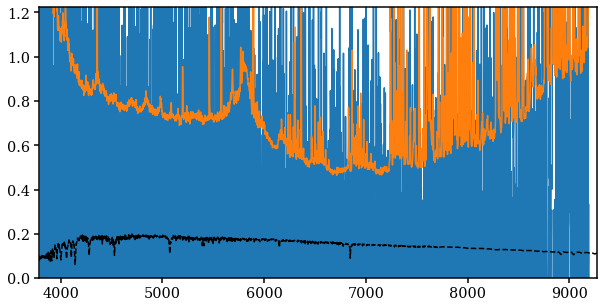

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


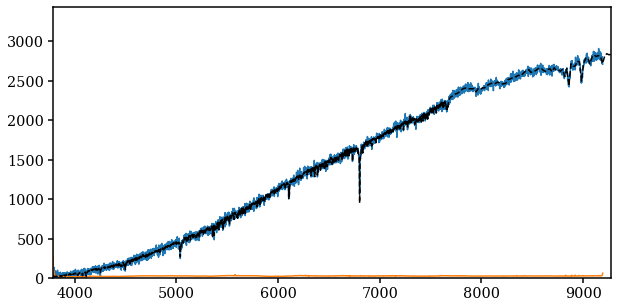

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


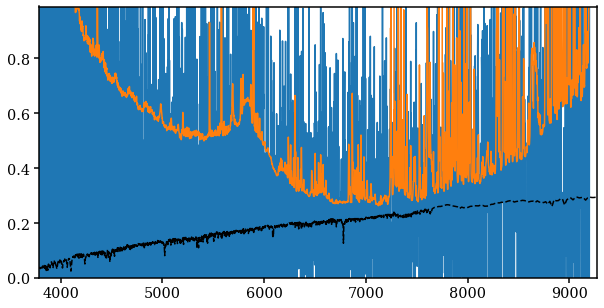

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


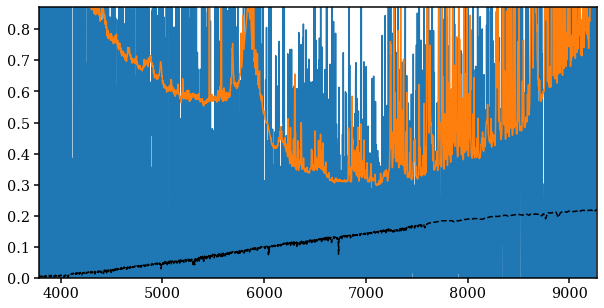

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


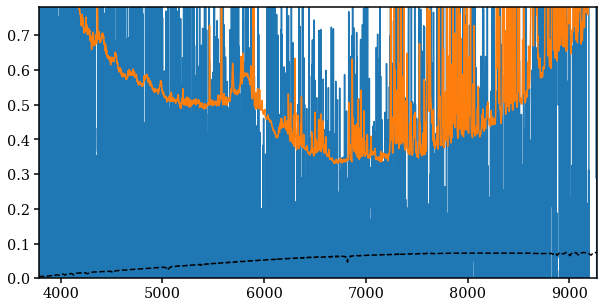

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


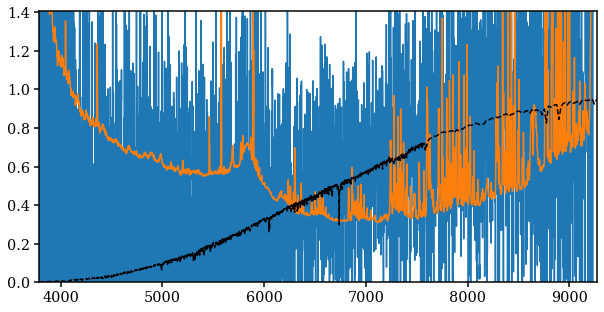

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


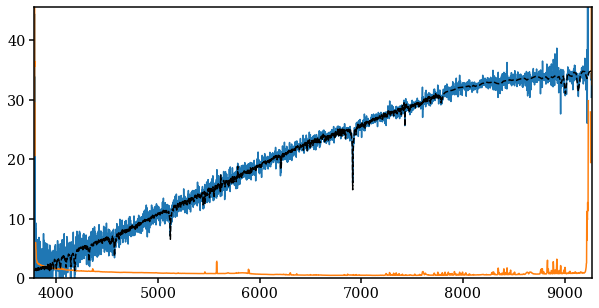

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


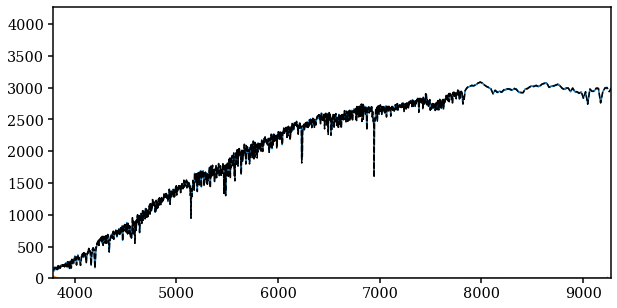

/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/home/chhahn/.conda/envs/torch-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


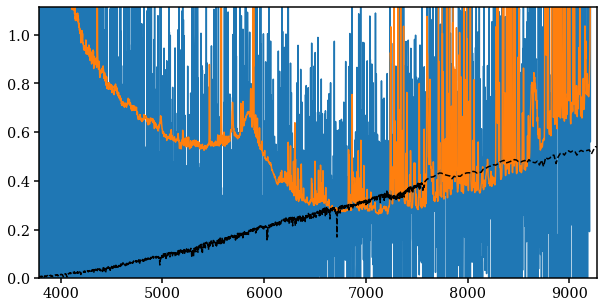

In [80]:
for w, sed, ivar in zip(wave, seds, ivar_recon):
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)
    
    sed_sdss = UT.trapz_rebin(w, sed, w_sdss) + ivar**-0.5 * np.random.normal(size=len(w_sdss))
    sub.plot(w_sdss, sed_sdss)
    sub.plot(w_sdss, ivar**-0.5)
    sub.plot(w, sed, c='k', ls='--')
    sub.set_xlim(w_sdss[0], w_sdss[-1])
    sub.set_ylim(0, 1.5*np.nanquantile(sed_sdss, 0.8))
    plt.show()